In [1]:
%matplotlib inline
import json
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import requests
import scipy.stats as stats
from matplotlib import pyplot as plt
from pathlib import Path

import apifacade as api
from censuscodes import county_lookup

In [2]:
# Set up the project resources directory, and the vacancy rates output directory
project_resources_dir = "resources"
project_output_dir = "output"
project_resources_path = Path(project_resources_dir)
project_output_path = Path(project_output_dir)
if not project_output_path.exists():
    project_output_path.mkdir()

# Set to True to force download from the Census Bureau's API
force_download = False

In [3]:
# Range of years for the project
project_years = list(range(2012, 2023))

bronx = county_lookup.by.full_name["Bronx County, New York"]
kings = county_lookup.by.full_name["Kings County, New York"]
new_york = county_lookup.by.full_name["New York County, New York"]
queens = county_lookup.by.full_name["Queens County, New York"]
richmond = county_lookup.by.full_name["Richmond County, New York"]

# NYC borough counties
project_counties = list(map(county_lookup.by.full_name.get, [
    "Bronx County, New York",
    "Kings County, New York",  # Brooklyn
    "New York County, New York",  # Manhattan
    "Queens County, New York",
    "Richmond County, New York",  # Staten Island
]))

In [4]:
# Display year and county information for all project years and counties
print(f"Project Years: {project_years}")
print("Project Counties:")
for county in project_counties:
    print(f"- {county.full_name} ("
          f"state_fips={county.state_fips}, "
          f"county_fips={county.fips})")

Project Years: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
Project Counties:
- Bronx County, New York (state_fips=36, county_fips=005)
- Kings County, New York (state_fips=36, county_fips=047)
- New York County, New York (state_fips=36, county_fips=061)
- Queens County, New York (state_fips=36, county_fips=081)
- Richmond County, New York (state_fips=36, county_fips=085)


In [5]:
# If a csv file exists and we don't want to force a download, load the data
# from the csv file and return it.
csv_path = Path(project_resources_dir) / "vacancy_rates.csv"
if csv_path.exists() and not force_download:
    df = pd.read_csv(csv_path, dtype={"state_fips": str, "county_fips": str})
else:
    # Otherwise, iterate over the years and counties to get the data, ...
    dfs = []
    for year in project_years:
        for county in project_counties:
            try:
                df = api.get_vacancy_rate(year, county)
                dfs.append(df)
            except RuntimeError as e:
                print(f"Error: {e}")
                continue

    # ... merge the data, rename and reorder the columns, ...
    df = pd.concat(dfs).reset_index(drop=True)
    df = df[["year", "state_fips", "county_fips",
             "vacant_units", "total_units",
             "vacancy_rate"]]
    
    # ... reformat the state and county FIPS codes, ...
    df["state_fips"] = df["state_fips"].astype(str).str.zfill(2)
    df["county_fips"] = df["county_fips"].astype(str).str.zfill(3)
    
    # ... and save the data to a csv file.  Saving the CSV file allows us to
    # avoid making time-consuming API requests to the Census Bureau in the
    # future, as well as merging, column renaming and reordering, etc.
    df.to_csv(csv_path, index=False)

In [6]:
# Display the head and tail of the merged data frame to review the data.
print(df.head())
print(df.tail())

   year state_fips county_fips  vacant_units  total_units  vacancy_rate
0  2012         36         005         38073       514051      7.406464
1  2012         36         047         83781      1003114      8.352092
2  2012         36         061        103804       850490     12.205199
3  2012         36         081         59798       840147      7.117564
4  2012         36         085         14011       177479      7.894455
    year state_fips county_fips  vacant_units  total_units  vacancy_rate
50  2022         36         005         24950       557985      4.471446
51  2022         36         047         75068      1101429      6.815510
52  2022         36         061        119395       923239     12.932188
53  2022         36         081         72060       911913      7.902070
54  2022         36         085         14551       184497      7.886849


In [7]:
# Get the data frame info to get a summary of the columns and data types.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          55 non-null     int64  
 1   state_fips    55 non-null     object 
 2   county_fips   55 non-null     object 
 3   vacant_units  55 non-null     int64  
 4   total_units   55 non-null     int64  
 5   vacancy_rate  55 non-null     float64
dtypes: float64(1), int64(3), object(2)
memory usage: 2.7+ KB


In [8]:
# Describe the vacant units, total units, and vacancy rate columns to get some
# quick statistics on the data.
df[["vacant_units", "total_units", "vacancy_rate"]].describe()

,vacant_units,total_units,vacancy_rate
count,55.000000,5.500000e+01,55.000000
mean,63783.618182,7.024252e+05,8.544318
std,41636.216396,3.134792e+05,3.251015
min,10406.000000,1.774790e+05,3.514892
25%,24723.000000,5.229480e+05,6.607700
50%,72060.000000,8.515760e+05,7.902070
75%,88028.000000,9.129195e+05,9.422309
max,179034.000000,1.101429e+06,19.532211


In [9]:
overall_df = df[["year", "vacant_units", "total_units"]].groupby("year").sum().reset_index()
overall_df["vacancy_rate"] = overall_df["vacant_units"] * 100.0 / overall_df["total_units"]
overall_df

,year,vacant_units,total_units,vacancy_rate
0,2012,299467,3385281,8.846149
1,2013,309625,3394486,9.121410
2,2014,290675,3438742,8.452946
3,2015,318831,3447978,9.246898
4,2016,349059,3463870,10.077139
5,2017,337670,3497344,9.655041
6,2018,334957,3519453,9.517303
7,2019,335568,3546601,9.461679
8,2020,248187,3618635,6.858581
9,2021,378036,3641931,10.380098


In [10]:
del overall_df["vacant_units"], overall_df["total_units"]
overall_df

,year,vacancy_rate
0,2012,8.846149
1,2013,9.121410
2,2014,8.452946
3,2015,9.246898
4,2016,10.077139
5,2017,9.655041
6,2018,9.517303
7,2019,9.461679
8,2020,6.858581
9,2021,10.380098


In [21]:
# Prepare data frames for each of the NYC boroughs
bronx_df = df.loc[df["county_fips"] == bronx.fips][["year", "vacancy_rate"]].copy().rename(columns={"vacancy_rate": "bronx_vacancy_rate"}).reset_index(drop=True)
kings_df = df.loc[df["county_fips"] == kings.fips][["year", "vacancy_rate"]].copy().rename(columns={"vacancy_rate": "kings_vacancy_rate"}).reset_index(drop=True)
new_york_df = df.loc[df["county_fips"] == new_york.fips][["year", "vacancy_rate"]].copy().rename(columns={"vacancy_rate": "new_york_vacancy_rate"}).reset_index(drop=True)
queens_df = df.loc[df["county_fips"] == queens.fips][["year", "vacancy_rate"]].copy().rename(columns={"vacancy_rate": "queens_vacancy_rate"}).reset_index(drop=True)
richmond_df = df.loc[df["county_fips"] == richmond.fips][["year", "vacancy_rate"]].copy().rename(columns={"vacancy_rate": "richmond_vacancy_rate"}).reset_index(drop=True)

# Merge the borough data frames to create a single data frame with all boroughs
boroughs_df = pd.merge(bronx_df, kings_df, on="year")
boroughs_df = pd.merge(boroughs_df, new_york_df, on="year")
boroughs_df = pd.merge(boroughs_df, queens_df, on="year")
boroughs_df = pd.merge(boroughs_df, richmond_df, on="year")

# Display the borough data frame to review the data.
print(boroughs_df)

    year  bronx_vacancy_rate  kings_vacancy_rate  new_york_vacancy_rate  \
0   2012            7.406464            8.352092              12.205199   
1   2013            6.840809            8.010488              14.811023   
2   2014            5.684071            7.839764              12.149582   
3   2015            5.388603            8.348386              13.639196   
4   2016            5.182507            8.655983              14.577450   
5   2017            4.701891            8.432931              13.782514   
6   2018            4.720859            8.005376              15.122049   
7   2019            4.338632            8.191762              13.968284   
8   2020            4.493355            6.296084              10.519889   
9   2021            3.514892            7.746367              19.532211   
10  2022            4.471446            6.815510              12.932188   

    queens_vacancy_rate  richmond_vacancy_rate  
0              7.117564               7.894455  
1

In [22]:
clean_df = df.copy()
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          55 non-null     int64  
 1   state_fips    55 non-null     object 
 2   county_fips   55 non-null     object 
 3   vacant_units  55 non-null     int64  
 4   total_units   55 non-null     int64  
 5   vacancy_rate  55 non-null     float64
dtypes: float64(1), int64(3), object(2)
memory usage: 2.7+ KB


In [70]:
clean_df["county"] = ""
for index, row in clean_df.iterrows():
    state_fips, county_fips = row["state_fips"], row["county_fips"]
    county_name = county_lookup.by.fips[state_fips][county_fips].name
    year = row["year"]
    period = "Before" if year < 2020 else "After"
    clean_df.loc[index, "county"] = county_name  # .replace(" County", "")
    clean_df.loc[index, "period"] = period
print(clean_df.head())
print(clean_df.tail())

   year state_fips county_fips  vacant_units  total_units  vacancy_rate  \
0  2012         36         005         38073       514051      7.406464   
1  2012         36         047         83781      1003114      8.352092   
2  2012         36         061        103804       850490     12.205199   
3  2012         36         081         59798       840147      7.117564   
4  2012         36         085         14011       177479      7.894455   

            county  period  
0     Bronx County  Before  
1     Kings County  Before  
2  New York County  Before  
3    Queens County  Before  
4  Richmond County  Before  
    year state_fips county_fips  vacant_units  total_units  vacancy_rate  \
50  2022         36         005         24950       557985      4.471446   
51  2022         36         047         75068      1101429      6.815510   
52  2022         36         061        119395       923239     12.932188   
53  2022         36         081         72060       911913      7.90207

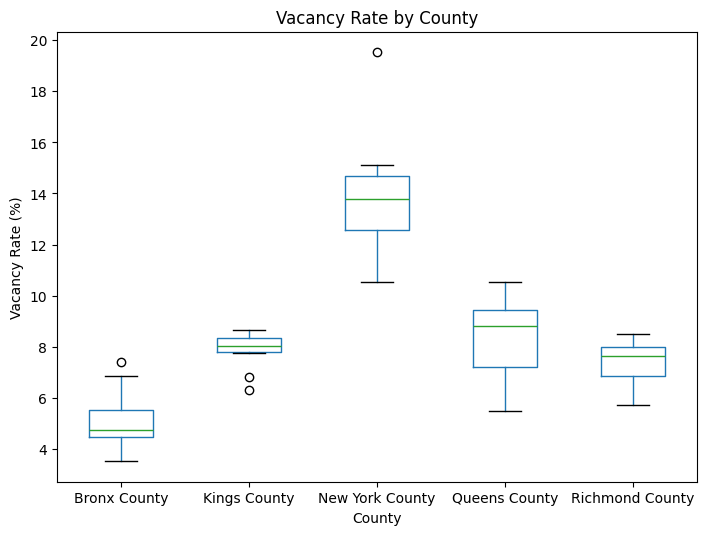

In [72]:
clean_df.boxplot("vacancy_rate", by="county",
                 grid=False, xlabel="County", ylabel="Vacancy Rate (%)", figsize=(8, 6))
plt.suptitle("")
plt.title("Vacancy Rate by County")
plt.savefig(f"{project_resources_dir}/vacancy_rate_by_county.png")
plt.show()

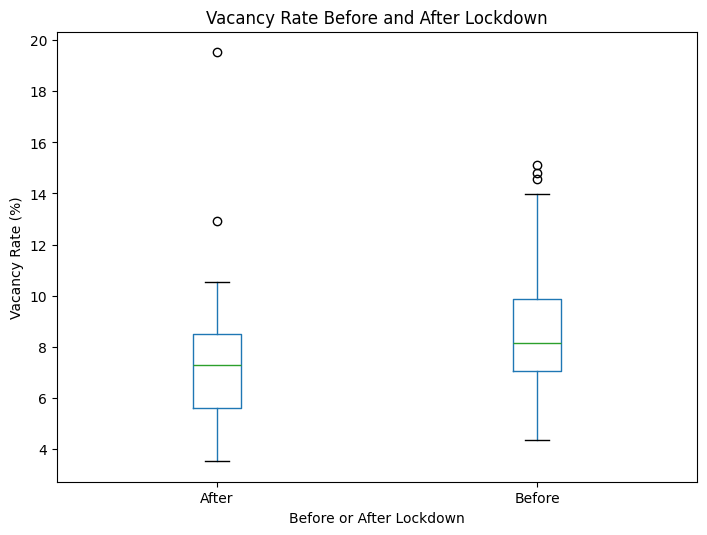

In [73]:
clean_df.boxplot("vacancy_rate", by="period",
                 grid=False, xlabel="Before or After Lockdown", ylabel="Vacancy Rate (%)", figsize=(8, 6))
plt.suptitle("")
plt.title("Vacancy Rate Before and After Lockdown")
plt.show()

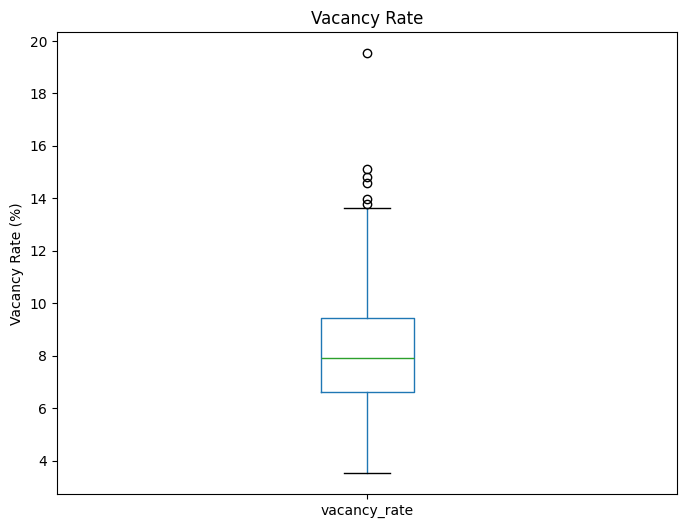

In [74]:
clean_df.boxplot("vacancy_rate",
                 grid=False, xlabel="", ylabel="Vacancy Rate (%)", figsize=(8, 6))
plt.suptitle("")
plt.title("Vacancy Rate")
plt.show()

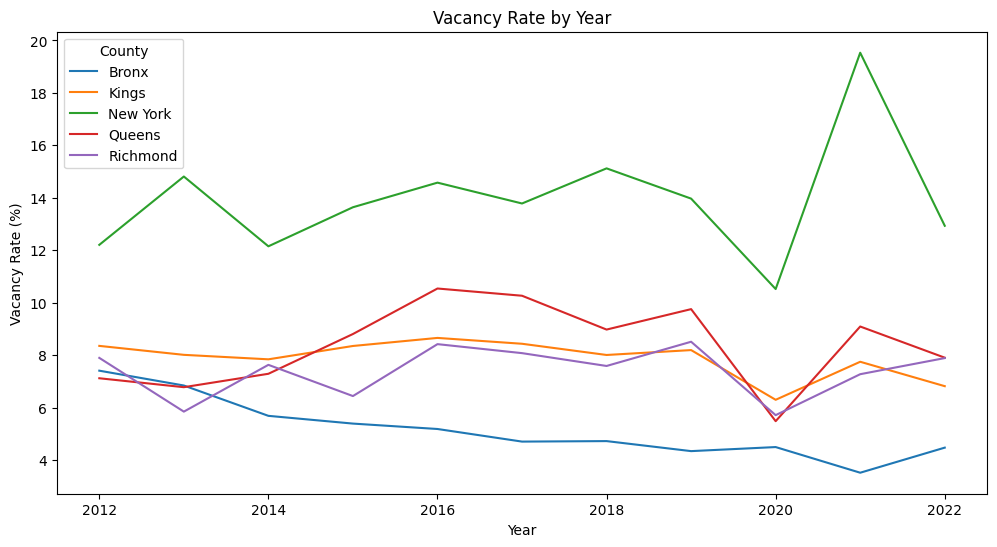

In [65]:
yearly_df = boroughs_df.copy().set_index("year")
plt.figure(figsize=(12, 6))
plt.plot(yearly_df.index, yearly_df["bronx_vacancy_rate"], label="Bronx")
plt.plot(yearly_df.index, yearly_df["kings_vacancy_rate"], label="Kings")
plt.plot(yearly_df.index, yearly_df["new_york_vacancy_rate"], label="New York")
plt.plot(yearly_df.index, yearly_df["queens_vacancy_rate"], label="Queens")
plt.plot(yearly_df.index, yearly_df["richmond_vacancy_rate"], label="Richmond")
plt.xlabel("Year")
plt.ylabel("Vacancy Rate (%)")
plt.title("Vacancy Rate by Year")
plt.legend(title="County")
plt.show()

In [75]:
clean_df

,year,state_fips,county_fips,vacant_units,total_units,vacancy_rate,county,period
0,2012,36,005,38073,514051,7.406464,Bronx County,Before
1,2012,36,047,83781,1003114,8.352092,Kings County,Before
2,2012,36,061,103804,850490,12.205199,New York County,Before
3,2012,36,081,59798,840147,7.117564,Queens County,Before
4,2012,36,085,14011,177479,7.894455,Richmond County,Before
5,2013,36,005,35331,516474,6.840809,Bronx County,Before
6,2013,36,047,80592,1006081,8.010488,Kings County,Before
7,2013,36,061,126285,852642,14.811023,New York County,Before
8,2013,36,081,57011,841254,6.776907,Queens County,Before
9,2013,36,085,10406,178035,5.844918,Richmond County,Before
